### Submitted By: PARVEJ ALAM M. ANSARI

# Task 02 - Exploratory Data Analysis

In this notebook, I have performed Exploratory Data Analysis on the datasets given by Sprocket Central Pty Ltd.

**“Market Segmentation: One Size Does Not Fit All.”**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
import os
from IPython.display import display
warnings.filterwarnings('ignore')

## Reading the Data

In [3]:
data = pd.ExcelFile("/home/ali/Documents/Forge_Internships/KPMG: Data Analytics/helper/KPMG_VI.xlsx")

In [4]:
Transactions = pd.read_excel(data, 'Transactions', header=1)
NewCustomerList = pd.read_excel(data, 'NewCustomerList', header=1)
CustomerDemographic = pd.read_excel(data, 'CustomerDemographic', header=1)
CustomerAddress = pd.read_excel(data, 'CustomerAddress', header=1)

## Exploratory Data Analysis

### Data Cleaning

These transformation have been done in the previous notebook, for more details make sure to check it out.

In [5]:
Transactions.dropna(inplace=True)

In [6]:
Transactions['product_first_sold_date'] = pd.to_datetime(Transactions['product_first_sold_date'], unit='s')
Transactions['product_first_sold_date'].head(5)

0   1970-01-01 11:27:25
1   1970-01-01 11:35:01
2   1970-01-01 10:06:01
3   1970-01-01 10:02:25
4   1970-01-01 11:43:46
Name: product_first_sold_date, dtype: datetime64[ns]

In [7]:
CustomerDemographic.loc[CustomerDemographic['gender'] == 'U', 'gender'] = 'Unspecified'
CustomerDemographic.loc[CustomerDemographic['gender'] == 'F', 'gender'] = 'Female'
CustomerDemographic.loc[CustomerDemographic['gender'] == 'Femal', 'gender'] = 'Female'
CustomerDemographic.loc[CustomerDemographic['gender'] == 'M', 'gender'] = 'Male'

In [8]:
CustomerDemographic = CustomerDemographic.drop('default', axis=1)

In [9]:
CustomerAddress.loc[CustomerAddress['state'] == 'New South Wales', 'state'] = 'NSW'
CustomerAddress.loc[CustomerAddress['state'] == 'Victoria', 'state'] = 'VIC'

In [10]:
NewCustomerList = NewCustomerList.drop(['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20'], axis=1)

> We decide to drop these colums since we don't have any information about what they actual represent. For the **Value** and the **Rank** columns, we will see below what to do with them.

In [11]:
NewCustomerList.loc[NewCustomerList['gender'] == 'U', 'gender'] = 'Unspecified'

### Data Integration

1. Merge CustomerAddress with Customer Demographics

In [12]:
OldCustomerList = pd.merge(CustomerDemographic, CustomerAddress, on='customer_id')
OldCustomerList.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016,NSW,Australia,10
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,6 Meadow Vale Court,2153,NSW,Australia,10
2,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,No,7.0,0 Holy Cross Court,4211,QLD,Australia,9
3,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,Yes,8.0,17979 Del Mar Point,2448,NSW,Australia,4
4,6,Curr,Duckhouse,Male,35,1966-09-16,NaN,Retail,High Net Worth,N,Yes,13.0,9 Oakridge Court,3216,VIC,Australia,9


2. Add extra columns to the **OldCustomerList** dataset from the **Transactions** dataset

For a little bit of context.
- **list_price** is a term used in retail and e-commerce to refer to the price at which a product is offered for sale to customers.
- **standard_cost** is the cost that a company incurs to produce or acquire a product or service. It includes the cost of raw materials, labor, manufacturing overhead, and other expenses that are directly or indirectly associated with the production process. 

Below, I will add three other columns that I will use in RFM clustering.
- **Recency:** How much time has elapsed since a customer’s last activity or transaction with the brand?
- **Frequency:** How often has a customer transacted or interacted with the brand during a particular period of time?
- **Monetary:** Also referred to as “monetary value,” this factor reflects how much a customer has spent with the brand during a particular period of time.

In [13]:
day = "2017-12-31"
day = pd.to_datetime(day)
Recency = Transactions.groupby('customer_id').agg({"transaction_date":lambda x:((day-x.max()).days)})
Recency = Recency.loc[:, ['transaction_date']]
Recency =  Recency.rename(columns={'transaction_date': 'recency'})
Recency.head(10)

,recency
customer_id,
1,8
2,129
3,103
4,196
5,17
6,65
7,254
8,23
9,79


In [14]:
OldCustomerList = OldCustomerList.merge(Recency, on='customer_id', how='left')

In [15]:
OldCustomerList['recency'].fillna(OldCustomerList['recency'].mean(), inplace=True)

In [16]:
Frequency = Transactions.groupby('customer_id').count()
Frequency = Frequency.loc[:, ['transaction_id']]
Frequency =  Frequency.rename(columns={'transaction_id': 'frequency'})
Frequency.head(5)

,frequency
customer_id,
1,11
2,3
3,7
4,2
5,6


In [17]:
OldCustomerList = OldCustomerList.merge(Frequency, on='customer_id', how='left')

In [18]:
Approved = Transactions.loc[Transactions['order_status'] == 'Approved'].groupby('customer_id').count()
Approved = Approved.loc[:, ['transaction_id']]
Approved =  Approved.rename(columns={'transaction_id': '% approved'})
Approved['% approved'] = Approved['% approved'] * 100 / Frequency['frequency']
Approved.head(5)  

,% approved
customer_id,
1,100.0
2,100.0
3,100.0
4,100.0
5,100.0


In [19]:
OldCustomerList = OldCustomerList.merge(Approved, on='customer_id', how='left')

In [20]:
OldCustomerList['% approved'].fillna(OldCustomerList['% approved'].mean(), inplace=True)

In [21]:
# Monetary
Monetary = Transactions.loc[Transactions['order_status'] == 'Approved'].groupby('customer_id').agg({'list_price': 'sum', 'standard_cost': 'sum'})
Monetary['monetary'] = Monetary['list_price'] - Monetary['standard_cost']
Monetary = Monetary.drop(['list_price', 'standard_cost'], axis=1)
Monetary

,monetary
customer_id,
1,3018.090000
2,2226.260000
3,3290.210000
4,220.570000
5,2394.940000
...,...
3497,1648.320000
3498,3147.330000
3499,4955.250000


In [22]:
OldCustomerList = OldCustomerList.merge(Monetary, on='customer_id', how='left')

In [23]:
OldCustomerList['monetary'].fillna(0, inplace=True)

3. Drop unnessecary columns.

In [24]:
NewCustomerList = NewCustomerList.drop(['Rank', 'Value'], axis=1)

### Features transformation

1. Add **age** column to both datasets

> Since the program was launched on 2017, our target year would be 2017.

In [25]:
OldCustomerList['DOB'] = pd.to_datetime(OldCustomerList['DOB'])
target_year = 2017
OldCustomerList['age'] = target_year - OldCustomerList['DOB'].dt.year

In [26]:
# Imputation of age with median
median_age = OldCustomerList['age'].median()
OldCustomerList['age'].fillna(median_age, inplace=True)

In [27]:
NewCustomerList['DOB'] = pd.to_datetime(NewCustomerList['DOB'])
NewCustomerList['age'] = target_year - NewCustomerList['DOB'].dt.year

In [28]:
# Imputation of age with median
median_age = NewCustomerList['age'].median()
NewCustomerList['age'].fillna(median_age, inplace=True)

In [29]:
OldCustomerList['age'].value_counts()

40.0     291
39.0     217
43.0     152
41.0     152
37.0     123
44.0     122
38.0     118
42.0     114
31.0     114
58.0      94
32.0      91
22.0      89
46.0      88
53.0      85
19.0      80
23.0      79
36.0      79
48.0      78
55.0      75
25.0      74
20.0      74
28.0      74
50.0      73
30.0      72
29.0      71
60.0      71
52.0      69
49.0      69
21.0      67
51.0      65
61.0      63
56.0      60
63.0      60
18.0      60
24.0      60
54.0      59
62.0      58
57.0      58
47.0      57
59.0      55
45.0      54
27.0      53
26.0      48
33.0      43
17.0      42
35.0      41
34.0      40
16.0      34
64.0      19
15.0       6
174.0      1
73.0       1
86.0       1
82.0       1
74.0       1
77.0       1
Name: age, dtype: int64

In [30]:
OldCustomerList = OldCustomerList[OldCustomerList['age'] < 174]

2. Change datatypes of some fields

In [31]:
NewCustomerList['age'] = NewCustomerList['age'].astype(int)

In [32]:
OldCustomerList['age'] = OldCustomerList['age'].astype(int)
OldCustomerList['frequency'] = OldCustomerList['frequency'].fillna(0)
OldCustomerList['frequency'] = OldCustomerList['frequency'].astype(int)

In [33]:
NewCustomerList['tenure'] = NewCustomerList['tenure'].astype(int)
OldCustomerList['tenure'] = OldCustomerList['tenure'].fillna(OldCustomerList['tenure'].mean())
OldCustomerList['tenure'] = OldCustomerList['tenure'].astype(int)

3. Transformation of **gender**, **deceased_indicator**, and **owns_car**. 

In [34]:
gender_map = {'Male': 0, 'Female': 1, 'Unspecified': 2}
OldCustomerList['gender'] = OldCustomerList['gender'].replace(gender_map)
NewCustomerList['gender'] = NewCustomerList['gender'].replace(gender_map)

In [35]:
deceased_map = {'N': 0, 'Y': 1}
OldCustomerList['deceased_indicator'] = OldCustomerList['deceased_indicator'].replace(deceased_map)
NewCustomerList['deceased_indicator'] = NewCustomerList['deceased_indicator'].replace(deceased_map)

In [36]:
car_map = {'No': 0, 'Yes': 1}
OldCustomerList['owns_car'] = OldCustomerList['owns_car'].replace(car_map)
NewCustomerList['owns_car'] = NewCustomerList['owns_car'].replace(car_map)

4. Reorder columns for both Datasets

In [37]:
OldCustomerList = OldCustomerList.reindex(columns=['customer_id', 'first_name', 'last_name', 'gender', 'age', 'DOB', 'address', 'postcode', 'country', 'state',
                                                   'job_title', 'job_industry_category', 'past_3_years_bike_related_purchases',
                                                   'property_valuation', 'wealth_segment', 'tenure', 'deceased_indicator', 'owns_car', 'frequency', 'monetary', 'recency', '% approved'])

In [38]:
NewCustomerList = NewCustomerList.reindex(columns=['first_name', 'last_name', 'gender', 'age', 'DOB', 'address', 'postcode', 'country', 'state',
                                                   'job_title', 'job_industry_category', 'past_3_years_bike_related_purchases',
                                                   'property_valuation', 'wealth_segment', 'tenure', 'deceased_indicator', 'owns_car'])

In [39]:
OldCustomerList.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3995 entries, 0 to 3995
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3995 non-null   int64         
 1   first_name                           3995 non-null   object        
 2   last_name                            3870 non-null   object        
 3   gender                               3995 non-null   int64         
 4   age                                  3995 non-null   int64         
 5   DOB                                  3908 non-null   datetime64[ns]
 6   address                              3995 non-null   object        
 7   postcode                             3995 non-null   int64         
 8   country                              3995 non-null   object        
 9   state                                3995 non-null   object        
 10  job_title   

In [40]:
NewCustomerList.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           1000 non-null   object        
 1   last_name                            971 non-null    object        
 2   gender                               1000 non-null   int64         
 3   age                                  1000 non-null   int64         
 4   DOB                                  983 non-null    datetime64[ns]
 5   address                              1000 non-null   object        
 6   postcode                             1000 non-null   int64         
 7   country                              1000 non-null   object        
 8   state                                1000 non-null   object        
 9   job_title                            894 non-null    object        
 10  job_industry_

### Data Visualization

In [41]:
total_old = float(len(OldCustomerList['gender']))
total_new = float(len(NewCustomerList['gender']))

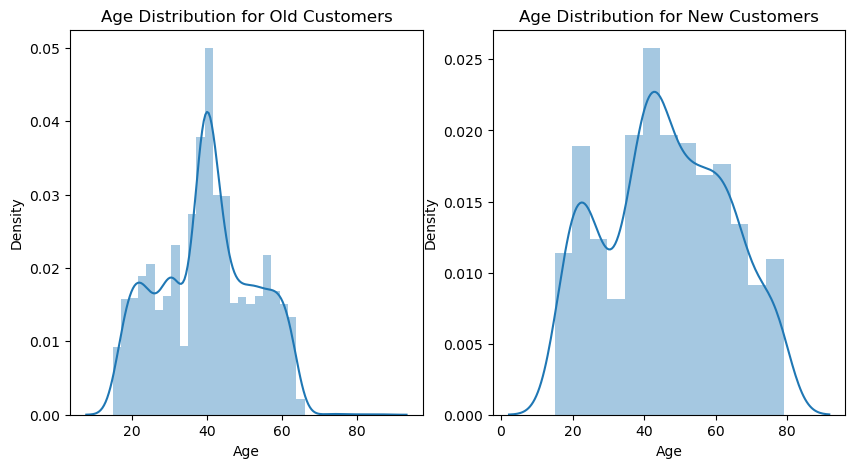

In [42]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the first subplot
sns.distplot(OldCustomerList['age'], ax=axs[0]);
axs[0].set_title('Age Distribution for Old Customers')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Density')

# Plot the second subplot
sns.distplot(NewCustomerList['age'], ax=axs[1]);
axs[1].set_title('Age Distribution for New Customers')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Density')

plt.show()

In [43]:
with pd.option_context('display.width', None):
    display(pd.concat([NewCustomerList['age'].describe(), OldCustomerList['age'].describe()], axis=1))

,age,age
count,1000.000000,3995.000000
mean,46.186000,39.934168
std,16.929087,12.473424
min,15.000000,15.000000
25%,34.750000,31.000000
50%,45.000000,40.000000
75%,60.000000,49.000000
max,79.000000,86.000000


> From the results above, we can see that the two distributions have some differences in their central tendency and variability. The distribution of age for new customers has a higher mean and a higher standard deviation, and larger quartiles, indicating that It is more spread out than the distribution of age for old customers. Therefore, we can say that the two distributions are not similar. Baring in mind that the first distribution has 3995 samples and the second one has only 1000 samples.

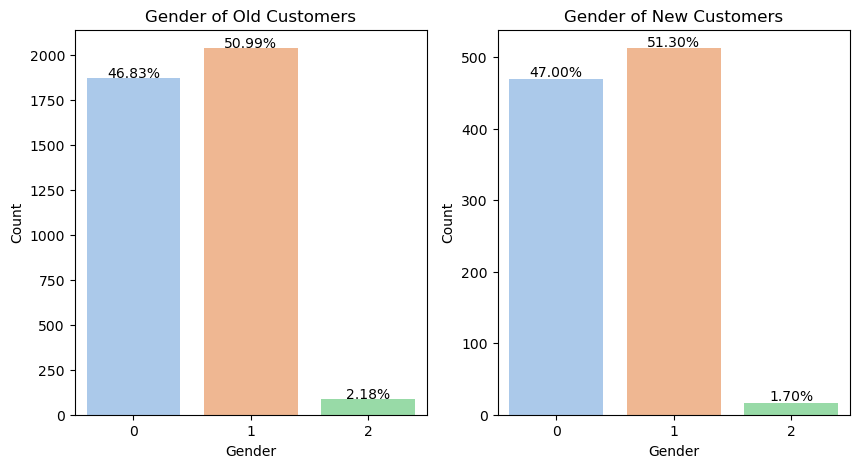

In [44]:
custom_palette = sns.color_palette('pastel', n_colors=3)
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the first subplot
sns.countplot(x="gender", data=OldCustomerList, palette=custom_palette, ax=axs[0])
for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total_old) * 100),
            ha="center")
axs[0].set_title('Gender of Old Customers')
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Count')


# Plot the first subplot
sns.countplot(x="gender", data=NewCustomerList, palette=custom_palette, ax=axs[1])
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total_new) * 100),
            ha="center")
axs[1].set_title('Gender of New Customers')
axs[1].set_xlabel('Gender')
axs[1].set_ylabel('Count')

plt.show()

> Both datasets tend to have the same % of women, men and unspecified gender.

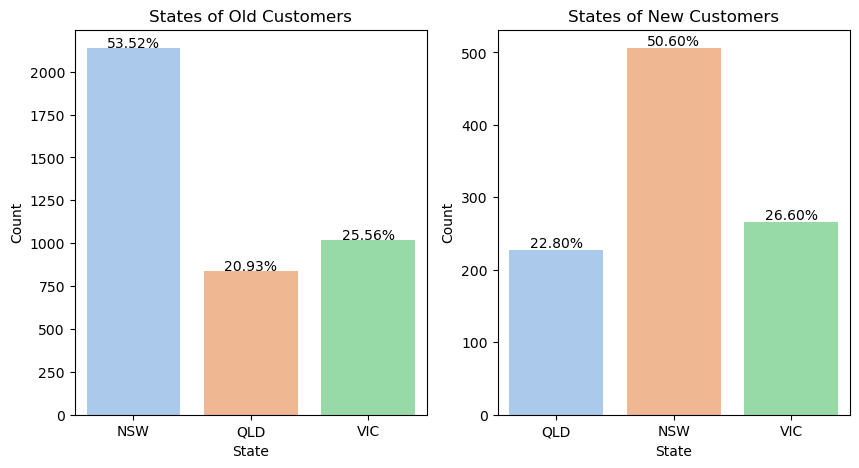

In [45]:
custom_palette = sns.color_palette('pastel', n_colors=3)
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the first subplot
sns.countplot(x="state", data=OldCustomerList, palette=custom_palette, ax=axs[0])
for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total_old) * 100),
            ha="center")
axs[0].set_title('States of Old Customers')
axs[0].set_xlabel('State')
axs[0].set_ylabel('Count')


# Plot the first subplot
sns.countplot(x="state", data=NewCustomerList, palette=custom_palette, ax=axs[1])
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total_new) * 100),
            ha="center")
axs[1].set_title('States of New Customers')
axs[1].set_xlabel('State')
axs[1].set_ylabel('Count')

plt.show()

> In both datasets, we notice that more than 50% of customers come from NSW, the rest are from VIC and QLD.

In [46]:
rfm_means = pd.DataFrame({'gender': [0,1,2],
                           'recency': OldCustomerList.groupby(['gender'])['recency'].mean().tolist(),
                           'frequency': OldCustomerList.groupby(['gender'])['frequency'].mean().tolist(),
                           'frequencies': OldCustomerList.groupby(['gender'])['frequency'].sum().tolist(),
                           'monetary': OldCustomerList.groupby(['gender'])['monetary'].mean().tolist(),
                           'monetaries': OldCustomerList.groupby(['gender'])['monetary'].sum().tolist(),
                          })
rfm_means

,gender,recency,frequency,frequencies,monetary,monetaries
0,0,63.492601,4.939604,9242,2712.647889,5075364.20
1,1,63.875792,4.779578,9736,2588.874065,5273536.47
2,2,53.912433,4.942529,430,3026.914138,263341.53


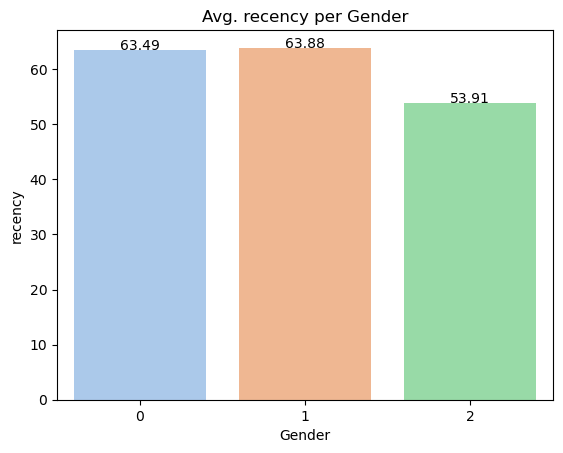

In [47]:
custom_palette = sns.color_palette('pastel', n_colors=3)
ax = sns.barplot(data=rfm_means, x='gender', y='recency', palette=custom_palette)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height,
            '{:.2f}'.format(height),
            ha="center")

ax.set_xlabel('Gender')
ax.set_ylabel('recency')
ax.set_title("Avg. recency per Gender")
plt.show()

> Female customers tend to have a slightly higher avg. recency comparing to male customers.

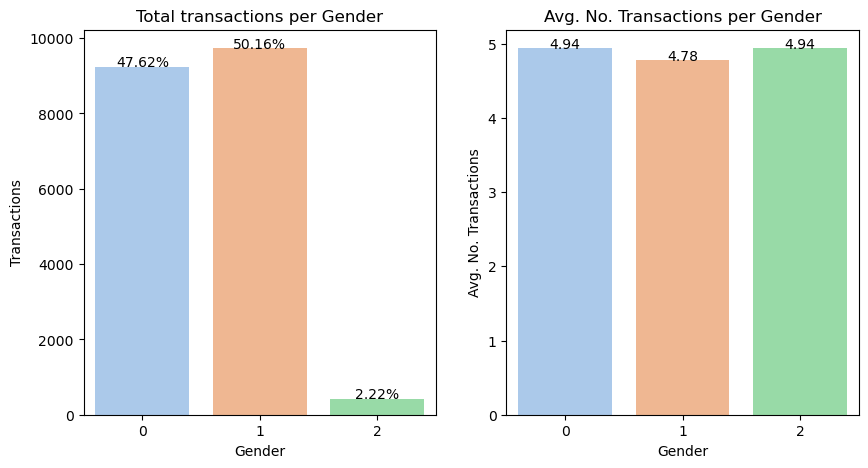

In [48]:
custom_palette = sns.color_palette('pastel', n_colors=3)
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the first subplot
sns.barplot(data=rfm_means, x='gender', y='frequencies', palette=custom_palette, ax=axs[0])
for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2.,
            height + 3.2,
            '{:.2f}%'.format(height * 100 / rfm_means['frequencies'].sum()),
            ha="center")
axs[0].set_title("Total transactions per Gender")
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Transactions')


# Plot the second subplot
sns.barplot(data=rfm_means, x='gender', y='frequency', palette=custom_palette, ax=axs[1])
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2.,
            height,
            '{:.2f}'.format((height)),
            ha="center")
axs[1].set_title('Avg. No. Transactions per Gender')
axs[1].set_xlabel('Gender')
axs[1].set_ylabel('Avg. No. Transactions')

plt.show()

> The total number of transactions made by female customers is higher. Though, men tend to have a higher avg. Number of transactions. Number of women customers is higher than the number of men customers in our dataset.

> **Remark**: One of the limitations is that we have 87 customers with an unspecified gender. Our analysis would be more concise If we had only females and males. One of the ways of addressing this issue to impute unspecified gender by mode, or other imputation methods. Or we can even go further by fixing this issue manually by check first names. Anyhow, for this analysis, we will keep the gender column as is, i.e with the three genders.

In [49]:
frequency = OldCustomerList.groupby(['state'])['frequency'].sum().tolist()
monetory = OldCustomerList.groupby(['state'])['monetary'].sum().tolist()
recency = OldCustomerList.groupby(['state'])['recency'].mean().tolist()

state_nt = pd.DataFrame({'state': sorted(OldCustomerList['state'].value_counts().index.tolist()), 
                         'frequency': frequency, 
                         'monetary': monetory,
                         'recency': monetory,
                        })

state_nt

,state,frequency,monetary,recency
0,NSW,10364,5633069.65,5633069.65
1,QLD,4136,2269758.24,2269758.24
2,VIC,4908,2709414.31,2709414.31


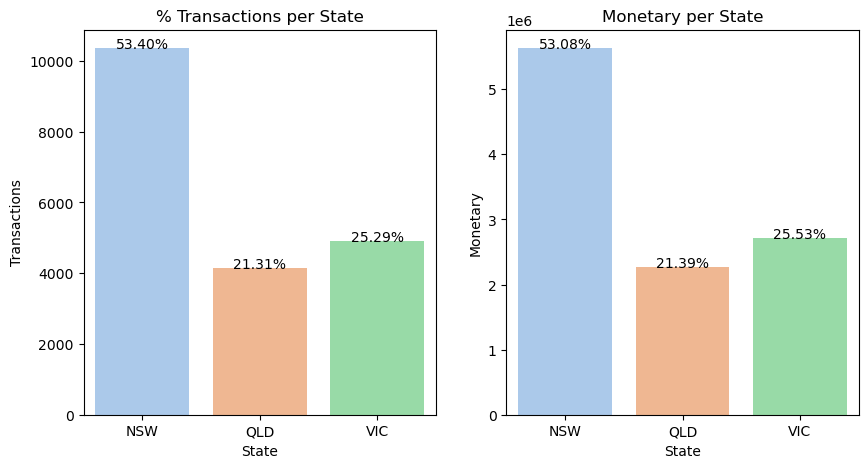

In [50]:
custom_palette = sns.color_palette('pastel', n_colors=3)
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the first subplot
sns.barplot(data=state_nt, x='state', y='frequency', palette=custom_palette, ax=axs[0])
for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2.,
            height + 3.2,
            '{:.2f}%'.format((height / state_nt['frequency'].sum()) * 100),
            ha="center")
axs[0].set_title("% Transactions per State")
axs[0].set_xlabel('State')
axs[0].set_ylabel('Transactions')


# Plot the second subplot
sns.barplot(data=state_nt, x='state', y='monetary', palette=custom_palette, ax=axs[1])
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2.,
            height + 1,
            '{:.2f}%'.format((height / state_nt['monetary'].sum()) * 100),
            ha="center")
axs[1].set_title('Monetary per State')
axs[1].set_xlabel('State')
axs[1].set_ylabel('Monetary')

plt.show()

> We can clearly notice that NSW has the highest % of transactions and monetory. Most customers come from NSW too. 

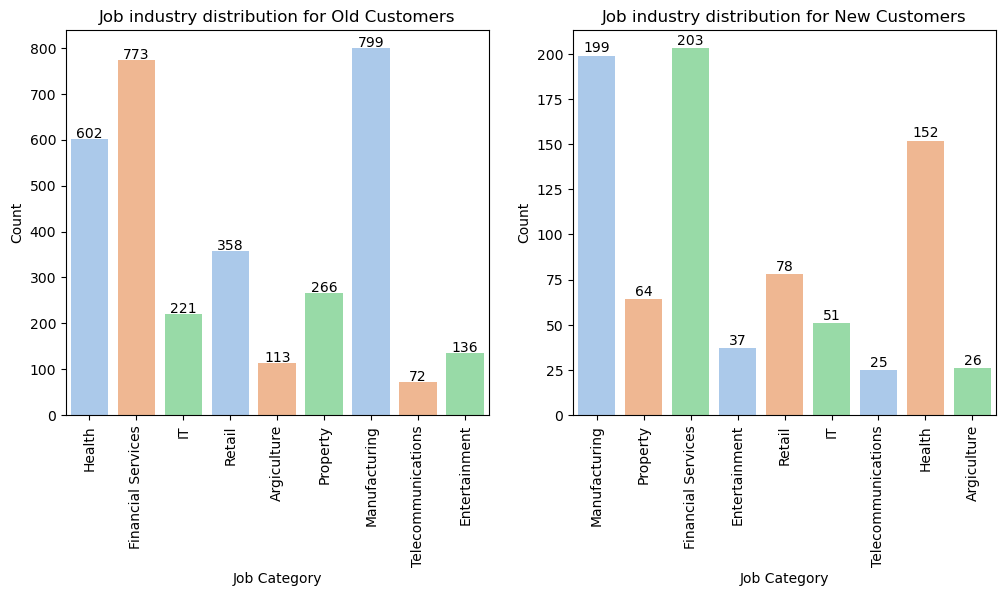

In [51]:
custom_palette = sns.color_palette('pastel', n_colors=3)
fig, axs = plt.subplots(ncols=2, figsize=(12,5))

# Plot the first subplot
sns.countplot(x="job_industry_category", data=OldCustomerList, palette=custom_palette, orient='v', ax=axs[0])
for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.0f}'.format(height),
            ha="center")
    
axs[0].set_title("Job industry distribution for Old Customers")
axs[0].set_xlabel('Job Category')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_ylabel('Count')


# Plot the second subplot
sns.countplot(x="job_industry_category", data=NewCustomerList, palette=custom_palette, orient='v', ax=axs[1])
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2.,
            height + 2,
            '{:.0f}'.format(height),
            ha="center")
    
axs[1].set_title("Job industry distribution for New Customers")
axs[1].set_xlabel('Job Category')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].set_ylabel('Count')

plt.show()

> We notice that the distribution of job industry category is pretty similar across both datasets. Most customers work in Manufacturing, Financial Services and Health.

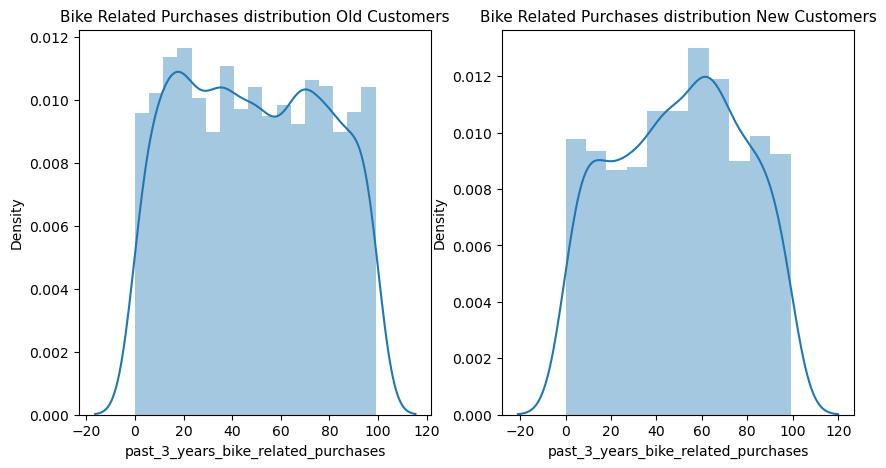

In [52]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the first subplot
sns.distplot(OldCustomerList['past_3_years_bike_related_purchases'], ax=axs[0]);
axs[0].set_title('Bike Related Purchases distribution Old Customers', fontsize=11)

# Plot the second subplot
sns.distplot(NewCustomerList['past_3_years_bike_related_purchases'], ax=axs[1]);
axs[1].set_title('Bike Related Purchases distribution New Customers', fontsize=11)

plt.show()

In [53]:
with pd.option_context('display.width', None):
    display(pd.concat([NewCustomerList['past_3_years_bike_related_purchases'].describe(), OldCustomerList['past_3_years_bike_related_purchases'].describe()], axis=1))

,past_3_years_bike_related_purchases,past_3_years_bike_related_purchases
count,1000.000000,3995.000000
mean,49.836000,48.878348
std,27.796686,28.727785
min,0.000000,0.000000
25%,26.750000,24.000000
50%,51.000000,48.000000
75%,72.000000,73.000000
max,99.000000,99.000000


> The summary statistics above suggest that there is not a significant difference between the past three years bike related purchases distribution for old and new customers.

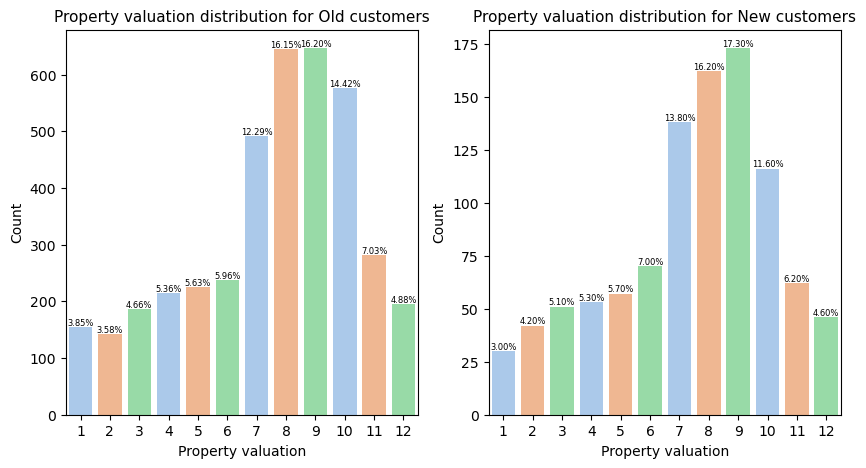

In [54]:
custom_palette = sns.color_palette('pastel', n_colors=3)
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the first subplot
sns.countplot(x="property_valuation", data=OldCustomerList, palette=custom_palette, orient='v', ax=axs[0])
for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total_old) * 100),
            ha="center",
            fontsize=6)
    
axs[0].set_title('Property valuation distribution for Old customers', fontsize=11)
axs[0].set_xlabel('Property valuation')
axs[0].set_ylabel('Count')


# Plot the second subplot
sns.countplot(x="property_valuation", data=NewCustomerList, palette=custom_palette, orient='v', ax=axs[1])
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2.,
            height + 1,
            '{:.2f}%'.format((height / total_new) * 100),
            ha="center",
            fontsize=6)
    
axs[1].set_title('Property valuation distribution for New customers', fontsize=11)
axs[1].set_xlabel('Property valuation')
axs[1].set_ylabel('Count')

plt.show()

> We notice that the distribution of property valuation is somewhat similar across both datasets.

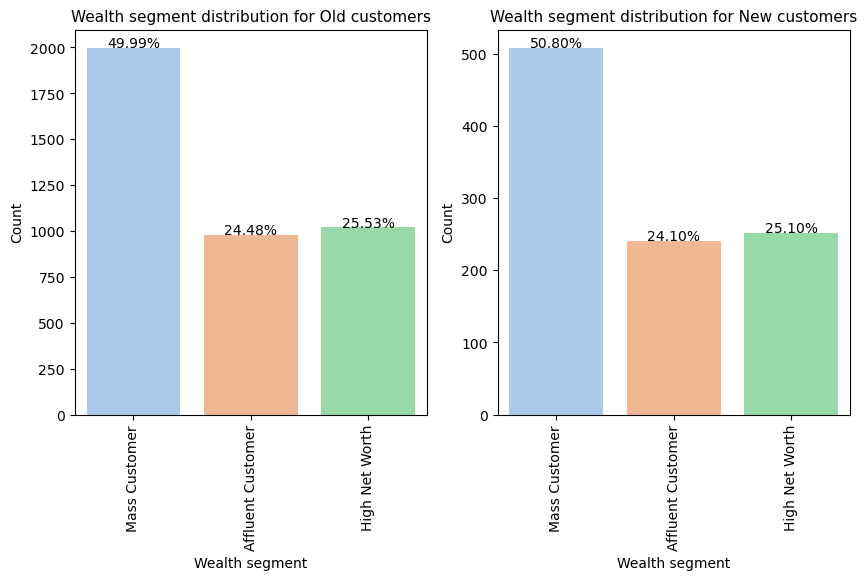

In [55]:
custom_palette = sns.color_palette('pastel', n_colors=3)
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the first subplot
sns.countplot(x="wealth_segment", data=OldCustomerList, palette=custom_palette, orient='v', ax=axs[0])
for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total_old) * 100),
            ha="center")
    
axs[0].set_title('Wealth segment distribution for Old customers', fontsize=11)
axs[0].set_xlabel('Wealth segment')
axs[0].set_ylabel('Count')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)


# Plot the second subplot
sns.countplot(x="wealth_segment", data=NewCustomerList, palette=custom_palette, orient='v', ax=axs[1])
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2.,
            height + 1,
            '{:.2f}%'.format((height / total_new) * 100),
            ha="center")
    
axs[1].set_title('Wealth segment distribution for New customers', fontsize=11)
axs[1].set_xlabel('Wealth segment')
axs[1].set_ylabel('Count')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)

plt.show()

> We notice that the distribution of wealth segment is pretty similar across both datasets. With most customer having a wealth segment of "Mass Customer".

In [56]:
frequency = OldCustomerList.groupby(['wealth_segment'])['frequency'].sum().tolist()
monetory = OldCustomerList.groupby(['wealth_segment'])['monetary'].sum().tolist()
recency = OldCustomerList.groupby(['wealth_segment'])['recency'].mean().tolist()

wealth_transaction = pd.DataFrame({'wealth_segment': sorted(OldCustomerList['wealth_segment'].value_counts().index.tolist()), 
                         'frequency': frequency, 
                         'monetary': monetory,
                         'recency': recency,
                        })

wealth_transaction

,wealth_segment,frequency,monetary,recency
0,Affluent Customer,4708,2586742.00,65.545627
1,High Net Worth,4955,2705590.89,62.074641
2,Mass Customer,9745,5319909.31,63.184912


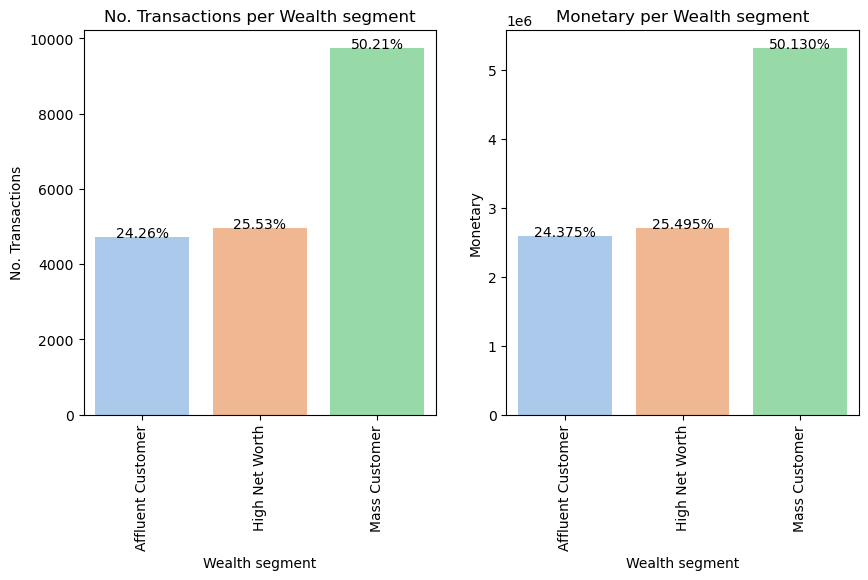

In [57]:
custom_palette = sns.color_palette('pastel', n_colors=3)
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the first subplot
sns.barplot(data=wealth_transaction , x='wealth_segment', y='frequency', palette=custom_palette, ax=axs[0])
for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / wealth_transaction['frequency'].sum()) * 100),
            ha="center")
axs[0].set_title("No. Transactions per Wealth segment")
axs[0].set_xlabel('Wealth segment')
axs[0].set_ylabel('No. Transactions')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

# Plot the second subplot
sns.barplot(data=wealth_transaction , x='wealth_segment', y='monetary', palette=custom_palette, ax=axs[1])
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2.,
            height,
            '{:.3f}%'.format((height*100) / wealth_transaction['monetary'].sum()),
            ha="center")
axs[1].set_title('Monetary per Wealth segment')
axs[1].set_xlabel('Wealth segment')
axs[1].set_ylabel('Monetary')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)

plt.show()

> All wealth segments tend to have approximatively the same avg. number of transaction.

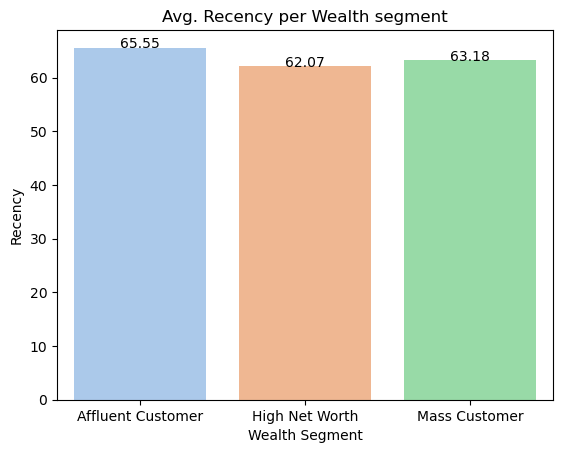

In [58]:
custom_palette = sns.color_palette('pastel', n_colors=3)
ax = sns.barplot(data=wealth_transaction, x='wealth_segment', y='recency', palette=custom_palette)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height,
            '{:.2f}'.format(height),
            ha="center")

ax.set_xlabel('Wealth Segment')
ax.set_ylabel('Recency')
ax.set_title("Avg. Recency per Wealth segment")
plt.show()

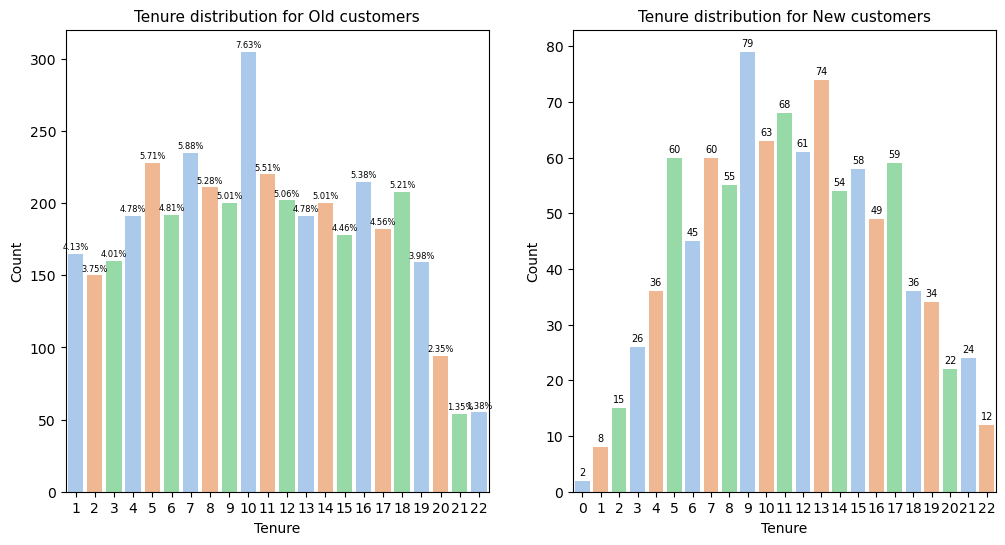

In [59]:
custom_palette = sns.color_palette('pastel', n_colors=3)
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

# Plot the first subplot
sns.countplot(x="tenure", data=OldCustomerList, palette=custom_palette, orient='v', ax=axs[0])
for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total_old) * 100),
            ha="center",
            fontsize=6)
    
axs[0].set_title('Tenure distribution for Old customers', fontsize=11)
axs[0].set_xlabel('Tenure')
axs[0].set_ylabel('Count')


# Plot the second subplot
sns.countplot(x="tenure", data=NewCustomerList, palette=custom_palette, orient='v', ax=axs[1])
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2.,
            height + 1,
            '{:.0f}'.format(height),
            ha="center",
            fontsize=7)
    
axs[1].set_title('Tenure distribution for New customers', fontsize=11)
axs[1].set_xlabel('Tenure')
axs[1].set_ylabel('Count')

plt.show()

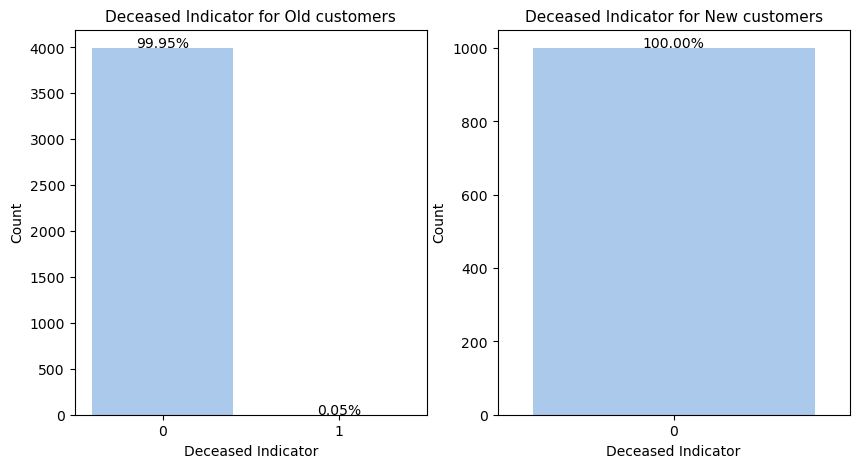

In [60]:
custom_palette = sns.color_palette('pastel', n_colors=3)
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the first subplot
sns.countplot(x="deceased_indicator", data=OldCustomerList, palette=custom_palette, orient='v', ax=axs[0])
for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total_old) * 100),
            ha="center")
    
axs[0].set_title('Deceased Indicator for Old customers', fontsize=11)
axs[0].set_xlabel('Deceased Indicator')
axs[0].set_ylabel('Count')


# Plot the second subplot
sns.countplot(x="deceased_indicator", data=NewCustomerList, palette=custom_palette, orient='v', ax=axs[1])
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2.,
            height + 1,
            '{:.2f}%'.format((height / total_new) * 100),
            ha="center")
    
axs[1].set_title('Deceased Indicator for New customers', fontsize=11)
axs[1].set_xlabel('Deceased Indicator')
axs[1].set_ylabel('Count')

plt.show()

> In the NewCustomerList all customers has a deceased_indicator of 0 (No), similarily with the OldCustomerList except two customers.

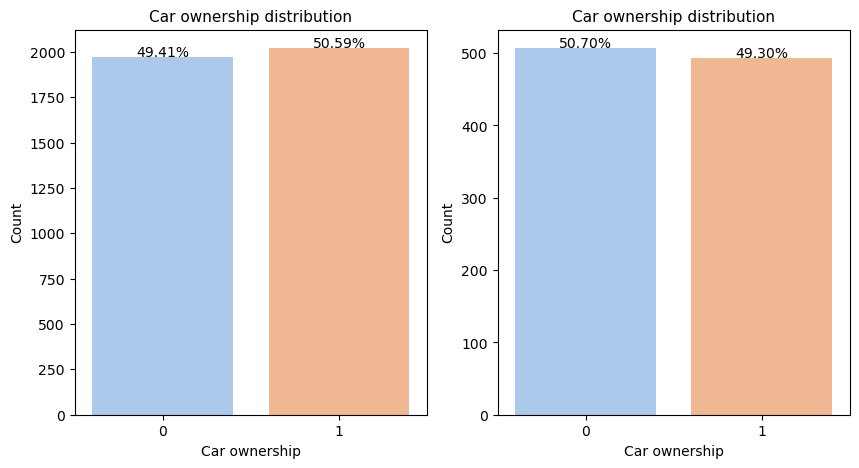

In [61]:
custom_palette = sns.color_palette('pastel', n_colors=3)
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the first subplot
sns.countplot(x="owns_car", data=OldCustomerList, palette=custom_palette, orient='v', ax=axs[0])
for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total_old) * 100),
            ha="center")
    
axs[0].set_title('Car ownership distribution', fontsize=11)
axs[0].set_xlabel('Car ownership')
axs[0].set_ylabel('Count')


# Plot the second subplot
sns.countplot(x="owns_car", data=NewCustomerList, palette=custom_palette, orient='v', ax=axs[1])
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2.,
            height + 1,
            '{:.2f}%'.format((height / total_new) * 100),
            ha="center")
    
axs[1].set_title('Car ownership distribution', fontsize=11)
axs[1].set_xlabel('Car ownership')
axs[1].set_ylabel('Count')

plt.show()

> We notice that the distribution of owns_car industry category is pretty similar across both datasets.

In [62]:
frequency = OldCustomerList.groupby(['owns_car'])['frequency'].sum().tolist()
monetory = OldCustomerList.groupby(['owns_car'])['monetary'].sum().tolist()
recency = OldCustomerList.groupby(['owns_car'])['recency'].mean().tolist()

cars_nt = pd.DataFrame({'owns_car': sorted(OldCustomerList['owns_car'].value_counts().index.tolist()), 
                         'frequency': frequency, 
                         'monetary': monetory,
                         'recency': recency,
                        })

cars_nt

,owns_car,frequency,monetary,recency
0,0,9627,5194183.73,64.456570
1,1,9781,5418058.47,62.524868


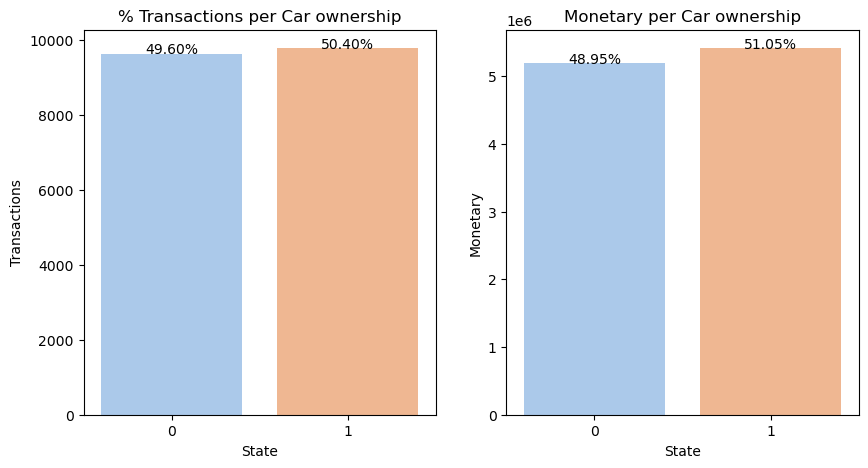

In [63]:
custom_palette = sns.color_palette('pastel', n_colors=3)
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the first subplot
sns.barplot(data=cars_nt, x='owns_car', y='frequency', palette=custom_palette, ax=axs[0])
for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / cars_nt['frequency'].sum()) * 100),
            ha="center")
axs[0].set_title("% Transactions per Car ownership")
axs[0].set_xlabel('State')
axs[0].set_ylabel('Transactions')


# Plot the second subplot
sns.barplot(data=cars_nt, x='owns_car', y='monetary', palette=custom_palette, ax=axs[1])
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2.,
            height,
            '{:.2f}%'.format((height / cars_nt['monetary'].sum()) * 100),
            ha="center")
axs[1].set_title('Monetary per Car ownership')
axs[1].set_xlabel('State')
axs[1].set_ylabel('Monetary')

plt.show()

### Relationships identification between different features

In [64]:
OldCustomerList.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3995 entries, 0 to 3995
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3995 non-null   int64         
 1   first_name                           3995 non-null   object        
 2   last_name                            3870 non-null   object        
 3   gender                               3995 non-null   int64         
 4   age                                  3995 non-null   int64         
 5   DOB                                  3908 non-null   datetime64[ns]
 6   address                              3995 non-null   object        
 7   postcode                             3995 non-null   int64         
 8   country                              3995 non-null   object        
 9   state                                3995 non-null   object        
 10  job_title   

Text(0.5, 1.0, 'Correlation Matrix')

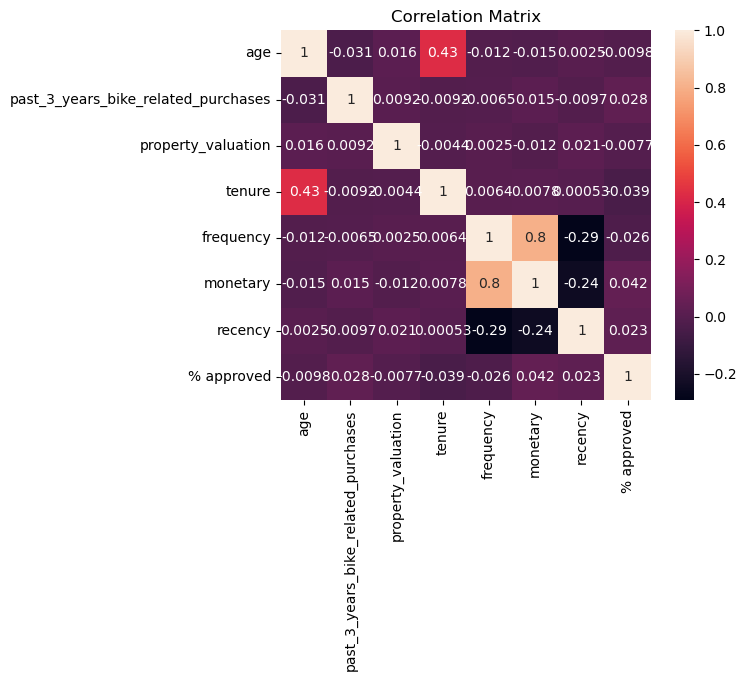

In [65]:
df_subset = OldCustomerList[['age', 'past_3_years_bike_related_purchases', 'property_valuation', 'tenure', 'frequency', 'monetary',  'recency', '% approved']]
mat = df_subset.corr()
corr_matrix = df_subset.corr()
sns.heatmap(mat, square=True, annot = True)
plt.title('Correlation Matrix')

In [66]:
# Save both datasets to Assets folder. Because some transformations will be done.
directory_path = "/home/ali/Documents/Forge_Internships/KPMG: Data Analytics/helper"
OldCustomerList.to_csv(os.path.join(directory_path, 'OldCustomerList.csv'), index=False)
NewCustomerList.to_csv(os.path.join(directory_path, 'NewCustomerList.csv'), index=False)
Transactions.to_csv(os.path.join(directory_path, 'Transactions.csv'), index=False)